In [112]:
%load_ext autoreload
%autoreload 2

from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()
flow_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_flight_flow_df_rev1.pickle"
flight_flow_data = pd.read_pickle(flow_matrix_path)

infection_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_infection_rate_df_rev1.pickle"
infection_matrix_df = pd.read_pickle(infection_matrix_path)

apt_df_path = "../recovery_rate/recovery_rate_training_dataframes/data/airport_state_weather_prediction_added_rev1.pickle"
airport_df = pd.read_pickle(apt_df_path)

mult_index = pd.MultiIndex.from_product([np.arange(np.datetime64("2018-01-01"), np.datetime64("2018-07-01")), range(0, 96, 4)], names=["date", "tw"])
new_df = pd.DataFrame(index=mult_index)

ff_list = []
inf_list = []
rr_list = []
p_state_list = []

for i in range(0, len(flight_flow_data), 133):
    rr_list.append(np.diag(airport_df.loc[:, "recovery_rate"].fillna(method="backfill").fillna(airport_df.loc[:, "recovery_rate"].median()).iloc[i:i+133].values))
    p_state_list.append(airport_df.loc[:, "norm_delay_per_f"].iloc[i:i+133].values.clip(min=0, max=1))
    ff_list.append(flight_flow_data.iloc[i:i+133, :].values)
    inf_list.append(infection_matrix_df.iloc[i:i+133, :].values)
    
new_df["rr_vector"] = rr_list
new_df["p_vector"] = p_state_list
new_df["infmat"] = inf_list
new_df["flowmat"] = ff_list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Delta P plots


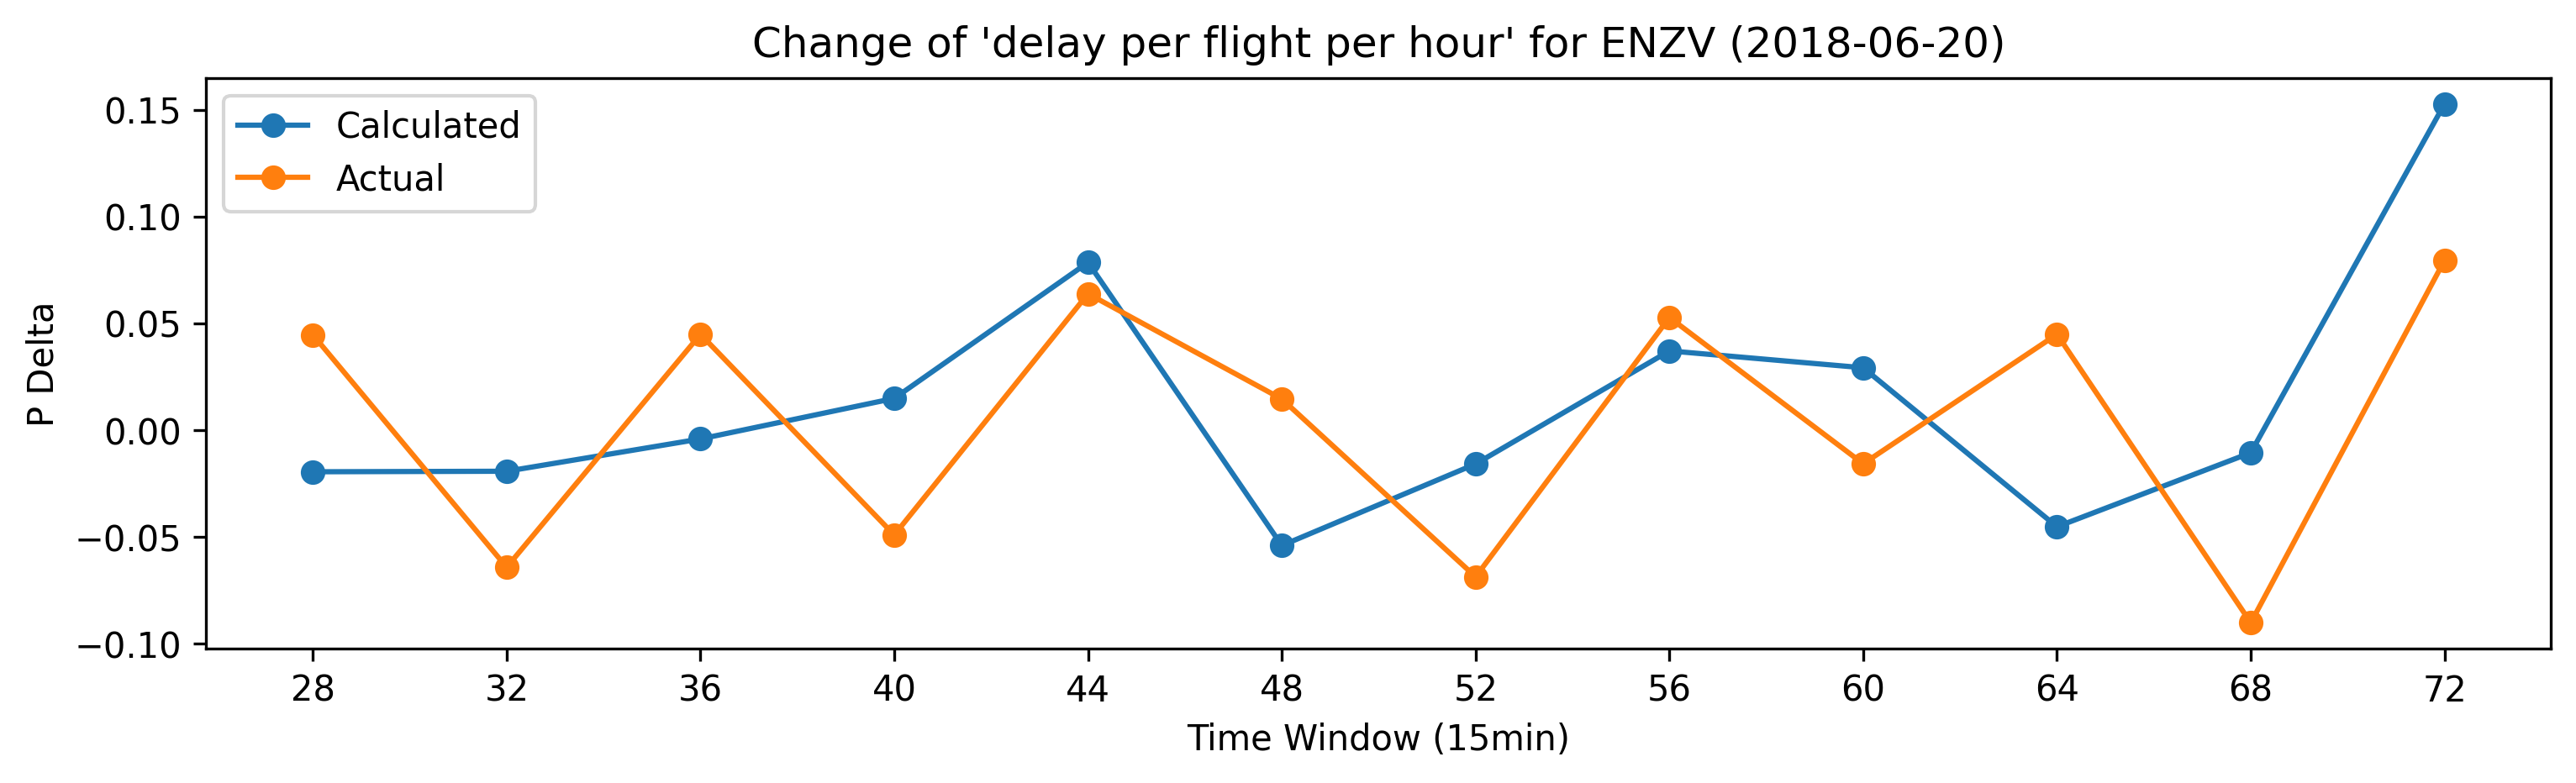

In [113]:
random = True
if random:
    date = str(rng.choice(np.arange(np.datetime64("2018-01-01"), np.datetime64("2018-07-01"))))
    tw=slice(24, 72, 1)
    apt_idx = rng.integers(0, 133)
else:
    date="2018-04-05"
    tw=slice(24, 72, 1)
    apt_idx = 5
    
index = (date, tw)

apt_name = airport_df.index.unique("apt").tolist()[apt_idx]

def diff_prop(slice_df):
    return (((slice_df["infmat"] - slice_df["rr_vector"]) @ slice_df["p_vector"]) - ((slice_df["infmat"] @ slice_df["p_vector"]) * slice_df["p_vector"])) / 1

slice_df = deepcopy(new_df.loc[index, :])

def apt_index(vector):
    return vector[apt_idx]

plot_kwargs = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P Delta", legend=True, xticks=range(28, 76, 4), title=f"Change of 'delay per flight per hour' for {apt_name} ({date})",
                   marker="o")

slice_df["calc_p"] = slice_df.apply(diff_prop, axis=1).values
slice_df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated")
slice_df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual")
plt.show()

## Delta P Plots with Uncertainties

In [114]:
from uncertainty_matrix_to_discrete import UncertaintyMatrix, divide_flowmats_to_interval, convert_flowmat_to_infmat

arrival_times = rng.integers(10, 150, size=(133, 133))
uncertainty_matrix = UncertaintyMatrix(new_df.loc[index, "flowmat"].iloc[0], mean_values=arrival_times)

In [117]:
sample_flowmats = [uncertainty_matrix.draw_sample() for i in range(100)]
sample_flowmats_divided = [divide_flowmats_to_interval(sample_flowmat, interval=15) for sample_flowmat in sample_flowmats]
sample_infmats = convert_flowmat_to_infmat(sample_flowmats_divided)

<AxesSubplot:title={'center':"Change of 'delay per flight per hour' for ENZV (2018-06-20)"}, xlabel='Time Window (15min)', ylabel='P Delta'>

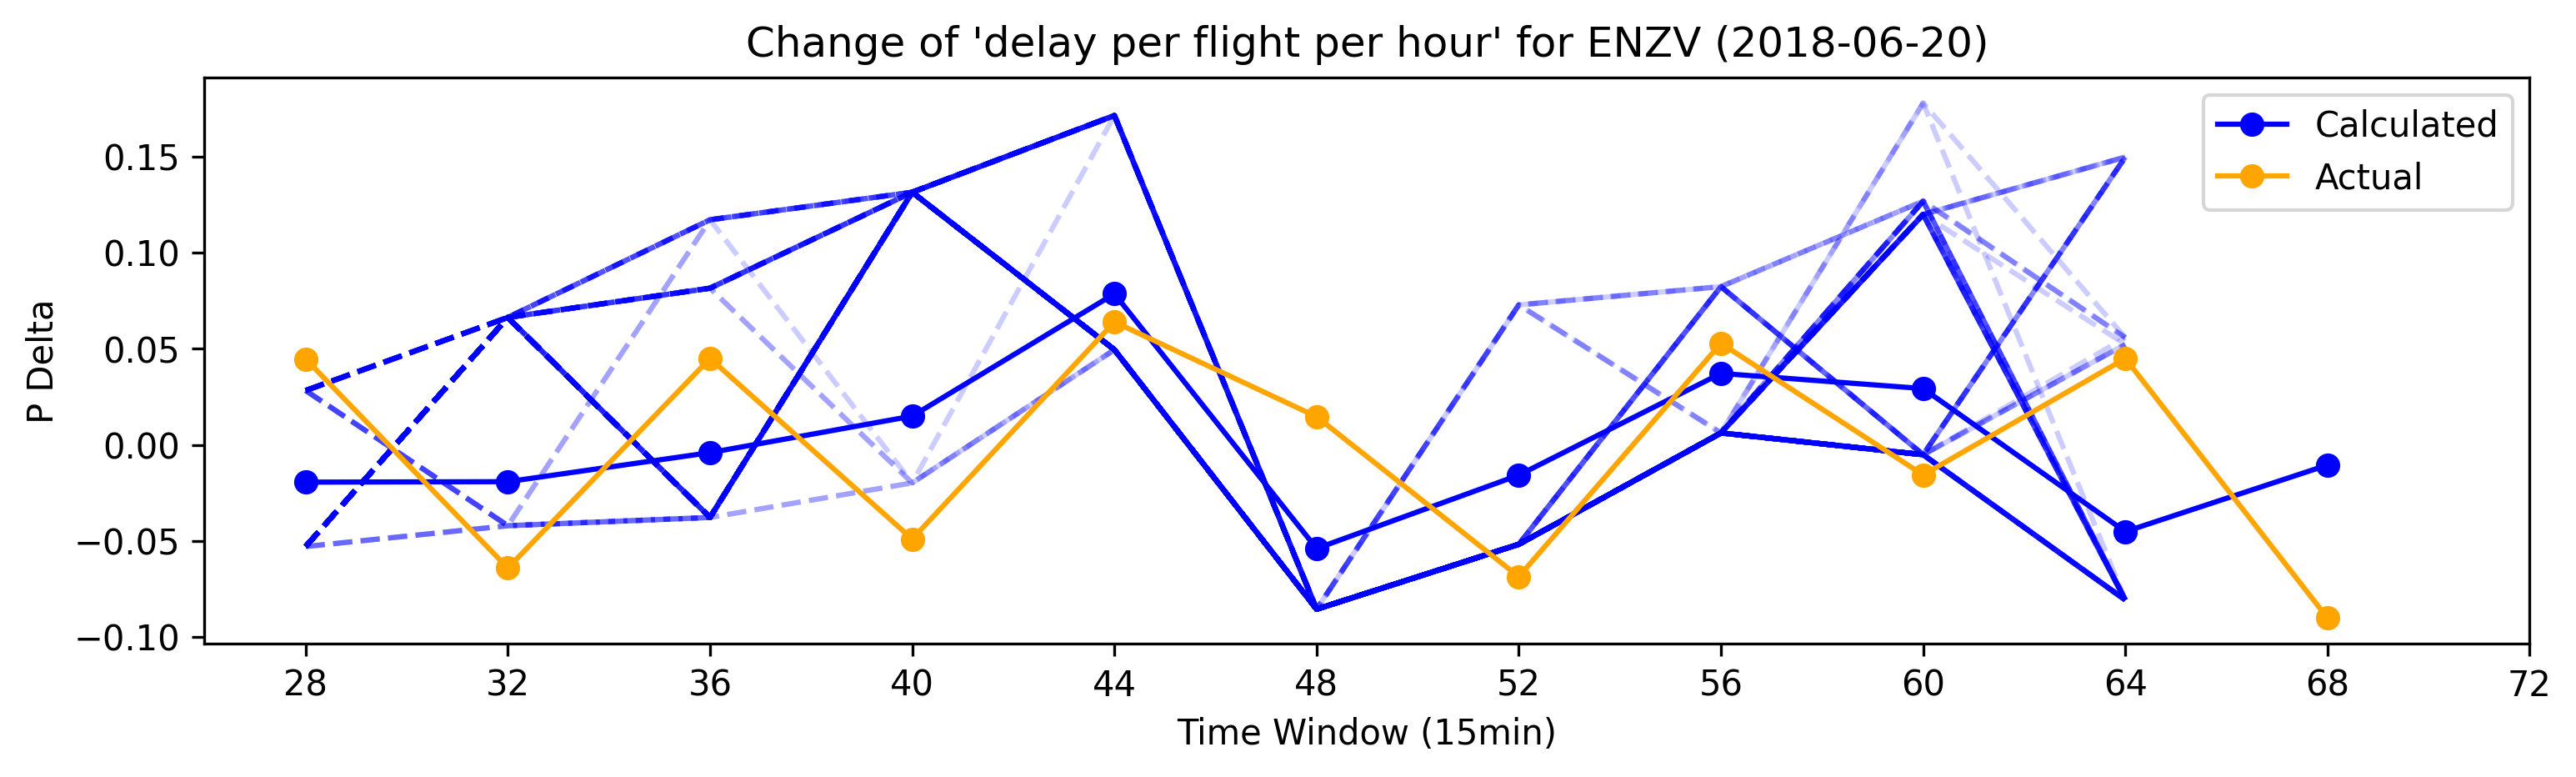

In [118]:
def diff_prop_new_infmat(slice_df):
    return (((slice_df["new_infmat"] - slice_df["rr_vector"]) @ slice_df["p_vector"]) - ((slice_df["new_infmat"] @ slice_df["p_vector"]) * slice_df["p_vector"])) / 1

plot_kwargs_for_uncertainty = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P Delta", xticks=range(28, 76, 4), title=f"Change of 'delay per flight per hour' for {apt_name} ({date})",
                   linestyle="--", alpha=0.2, color="b")

calculation_history = []
for infmat_sequence in sample_infmats:
    df = deepcopy(slice_df.iloc[0:len(infmat_sequence), :])
    df["new_infmat"] = infmat_sequence
    df["calc_with_new_infmat"] = df.apply(diff_prop_new_infmat, axis=1).values
    df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs_for_uncertainty)
    calculation_history.append(df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).values)
    
df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated", color="b")
df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual", color="orange")

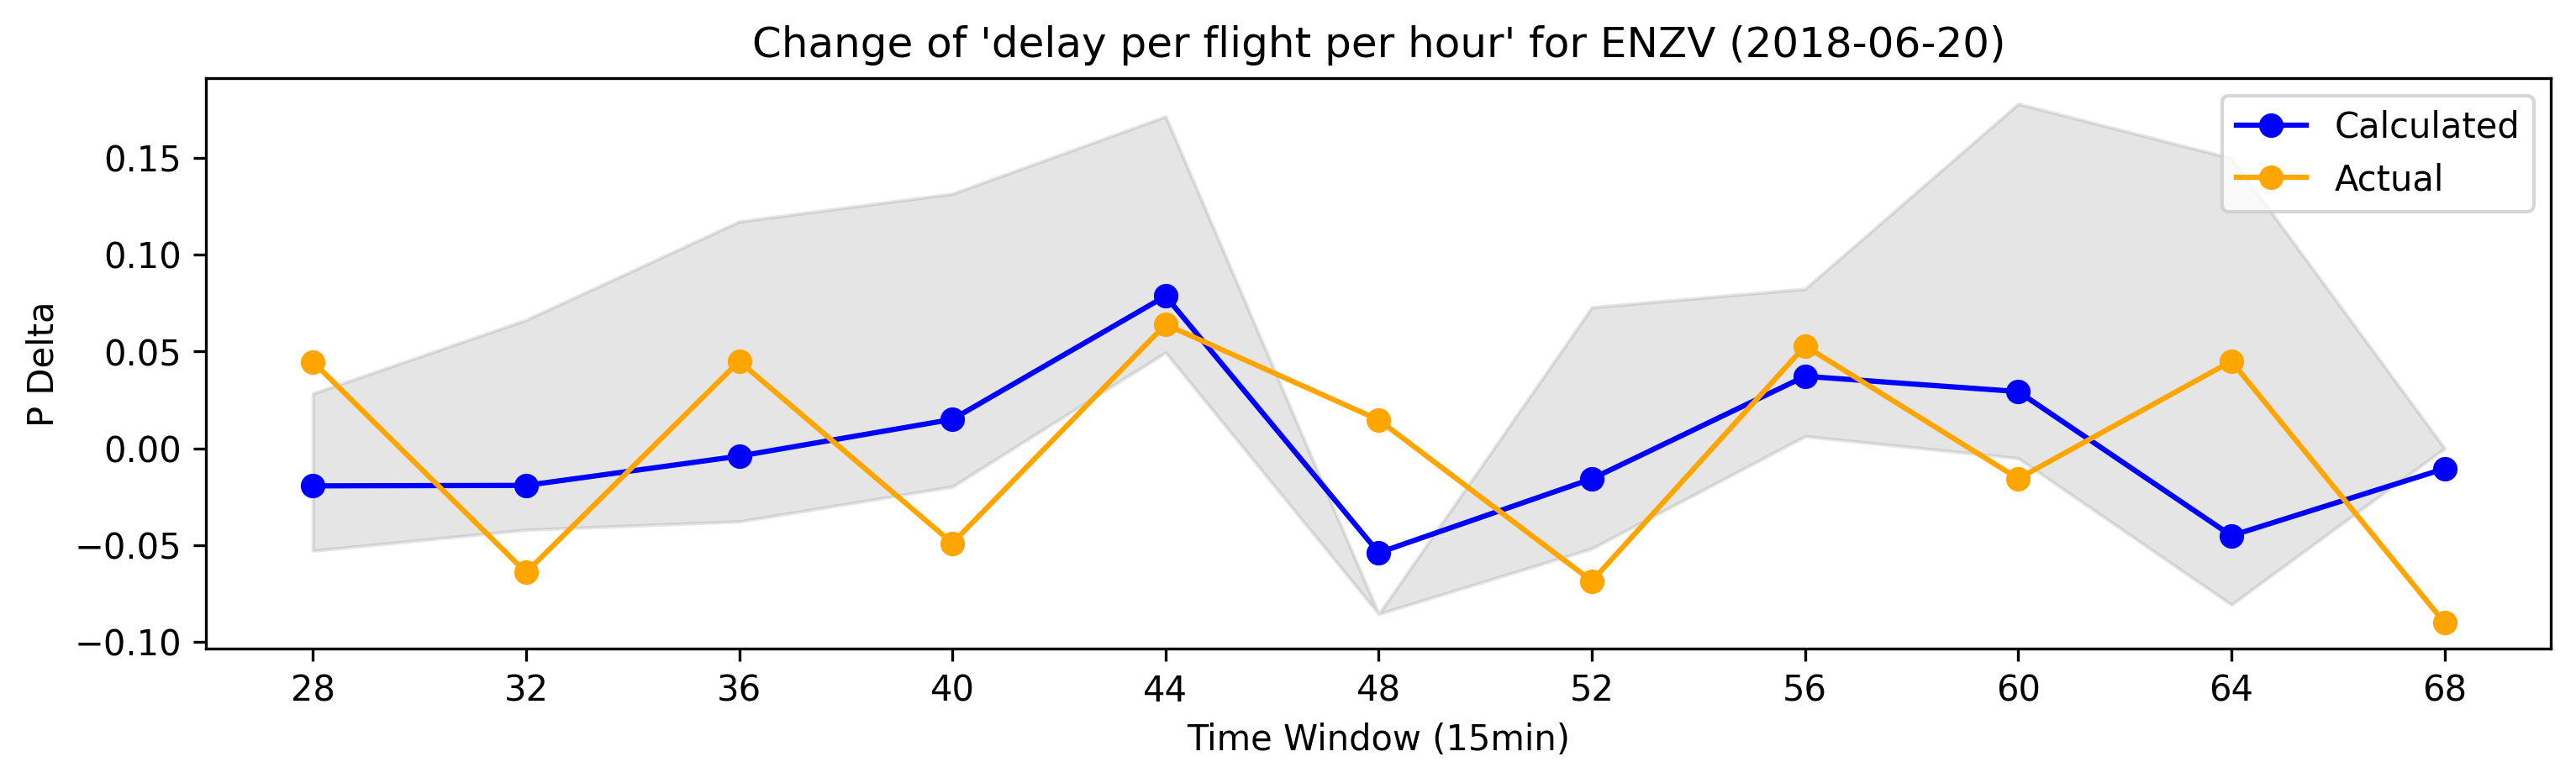

In [124]:
def pad_arrays(expected_len, array_list):
    padded_calc_history = []
    expected_array_len = 12

    for array in calculation_history:
        
        len_deficit = expected_array_len - array.shape[0]
        while len_deficit < 0:
            expected_array_len = array.shape[0]
            len_deficit = expected_array_len - array.shape[0]
            
        if len_deficit != 0:
            padded_calc_history.append(np.pad(array, (0, len_deficit), constant_values=0))
        else:
            padded_calc_history.append(array)
            
    return padded_calc_history

df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated", color="b")
df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual", color="orange")

padded_calc_history = pad_arrays(12, calculation_history)
max_p_delta_values = np.nan_to_num(np.vstack(padded_calc_history)).max(axis=0)
min_p_delta_values = np.nan_to_num(np.vstack(padded_calc_history)).min(axis=0)
plt.gca().fill_between(x=range(28, 72, 4), y1=max_p_delta_values[1:], y2=min_p_delta_values[1:], color="gray", alpha=0.2)